In [1]:
from Twitter import TwitterAccess
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from collections import Counter
pd.options.display.max_colwidth = None
import nltk
import string
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from spellchecker import SpellChecker
import random
import numpy as np
from multiprocessing import  Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin # ???
from sklearn.utils.validation import check_X_y, check_is_fitted # ???
from scipy import sparse #???
from sklearn.linear_model import LogisticRegression


[nltk_data] Downloading package stopwords to /u/arsaikia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
olid = pd.read_csv('./olid.csv')
olid = olid[~pd.isna(olid['tweet_cleaned'])]

olid_test = pd.read_csv('./olid-levela.csv')
olid_test = olid_test[~pd.isna(olid_test['tweet_cleaned'])]

In [3]:
olid.head()

,id,tweet,subtask_a,subtask_b,subtask_c,tweet_cleaned
0,86426,@USER She should ask a few native Americans what their take on this is.,OFF,UNT,NaN,she should ask a few native americans what their take on this is
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL,OFF,TIN,IND,go home you’re drunk
2,16820,Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT,NOT,NaN,NaN,amazon is investigating chinese employees who are selling internal data to thirdparty sellers looking for an edge in the competitive marketplace
3,62688,"@USER Someone should'veTaken"" this piece of shit to a volcano. 😂""",OFF,UNT,NaN,someone shouldvetaken this piece of shit to a volcano
4,43605,@USER @USER Obama wanted liberals &amp; illegals to move into red states,NOT,NaN,NaN,obama wanted liberals illegals to move into red states


# TFIDF Baseline

In [4]:
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def pr(self, x, y_i, y):
        p = x[y==y_i].sum(0)
        return (p+1) / ((y==y_i).sum()+1)
    
    def fit(self, x, y):
        # Check that X and y have correct shape
#         y = y
        x, y = check_X_y(x, y, accept_sparse=True)
        self._r = sparse.csr_matrix(np.log(self.pr(x,1,y) / self.pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs, solver ='liblinear').fit(x_nb, y)
        self.coef_ = self._clf.coef_
        return self

### Train-validate

In [5]:
le = LabelEncoder()
y = le.fit_transform(olid['subtask_a'])

tfv = TfidfVectorizer(tokenizer=nltk.casual_tokenize, min_df=20,  max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
X = tfv.fit_transform(olid['tweet_cleaned']).tocsr()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

model = NbSvmClassifier(C=4, dual=True, n_jobs=1)

model.fit(X_train, y_train)
preds_valid = model.predict(X_valid)
proba_valid = model.predict_proba(X_valid)[:,1]
preds_train = model.predict(X_train)
proba_train = model.predict_proba(X_train)[:,1]


print(classification_report(y_train, preds_train))
print('AUC: ', roc_auc_score(y_train, proba_train))

print(classification_report(y_valid, preds_valid))
print('AUC: ',  roc_auc_score(y_valid, proba_valid))


(8870, 1084) (4369, 1084) (8870,) (4369,)
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      5922
           1       0.80      0.51      0.63      2948

    accuracy                           0.80      8870
   macro avg       0.80      0.73      0.74      8870
weighted avg       0.80      0.80      0.78      8870

AUC:  0.8442547669683269
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      2917
           1       0.73      0.45      0.56      1452

    accuracy                           0.76      4369
   macro avg       0.75      0.68      0.70      4369
weighted avg       0.76      0.76      0.74      4369

AUC:  0.7621498511150084


### Feature Importance

Text(0.5, 0.98, 'Feature Importances')

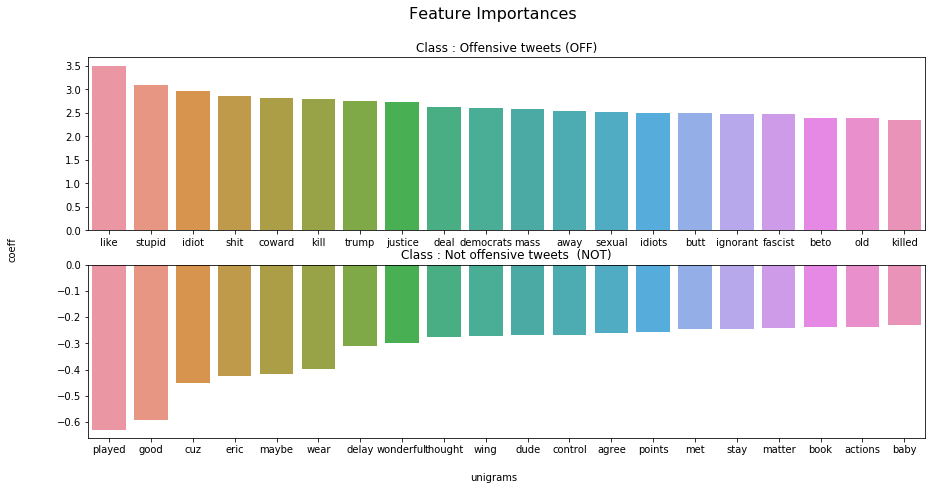

In [6]:
def top_lr_feats(features,row, top_n=25, pos = True):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    if pos == True:
        topn_ids = np.argsort(row)[::-1][:top_n]
    else:
        topn_ids = np.argsort(row)[:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    return df.iloc[:,0].values, df.iloc[:,1].values


fig,(ax1,ax2)=plt.subplots(2,1,figsize=(15,7))

features = np.array(tfv.get_feature_names())
x, y = top_lr_feats(features,  model.coef_[0],top_n = 20, pos = True)
sns.barplot(x, y, ax = ax1)
ax1.set_title('Class : Offensive tweets (OFF)')
x, y = top_lr_feats(features, model.coef_[0], top_n = 20, pos = False)
sns.barplot(x, y, ax = ax2)
ax2.set_title('Class : Not offensive tweets  (NOT)')

fig.text(0.5, 0.04, 'unigrams', ha='center')
fig.text(0.05, 0.5, 'coeff', va='center',  rotation='vertical')
fig.suptitle('Feature Importances', fontsize=16)
# sns.barplot(features,model.coef_[0])

### Test

In [7]:
le = LabelEncoder()
y = le.fit_transform(olid['subtask_a'])

tfv = TfidfVectorizer(tokenizer=nltk.casual_tokenize, min_df=20,  max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
X = tfv.fit_transform(olid['tweet_cleaned']).tocsr()

model = NbSvmClassifier(C=4, dual=True, n_jobs=1)

model.fit(X, y)

y_test = le.transform(olid_test['subtask_a'])
X_test = tfv.transform(olid_test['tweet_cleaned']).tocsr()

print(X_test.shape, y_test.shape)
preds_test = model.predict(X_test)
proba_test = model.predict_proba(X_test)[:,1]


print(classification_report(y_test, preds_test))
print('AUC: ',  roc_auc_score(y_test, proba_test))



(859, 1084) (859,)
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       619
           1       0.78      0.47      0.58       240

    accuracy                           0.81       859
   macro avg       0.80      0.71      0.73       859
weighted avg       0.81      0.81      0.80       859

AUC:  0.7697260366182015


# Glove LSTM Baseline

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def create_corpus(tweets):
    stop=set(stopwords.words('english'))
    corpus=[]
    for tweet in tqdm(tweets):
#         words=[word.lower() for word in nltk.casual_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        words=[word.lower() for word in nltk.casual_tokenize(tweet)]
        corpus.append(words)
    return corpus

corpus=create_corpus(olid['tweet_cleaned'])

embedding_dict={}
# with open('./data/glove6B/glove.6B.100d.txt','r') as f:
with open('./data/gloveTwitter27B/glove.twitter.27B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus) #??
sequences=tokenizer_obj.texts_to_sequences(corpus) #??

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec
        
        
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=True)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

model.summary()

100%|██████████| 19059/19059 [00:00<00:00, 533091.75it/s]

Number of unique words: 19059


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1906000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,948,305
Trainable params: 1,948,305
Non-trainable params: 0
_________________________________________________________________


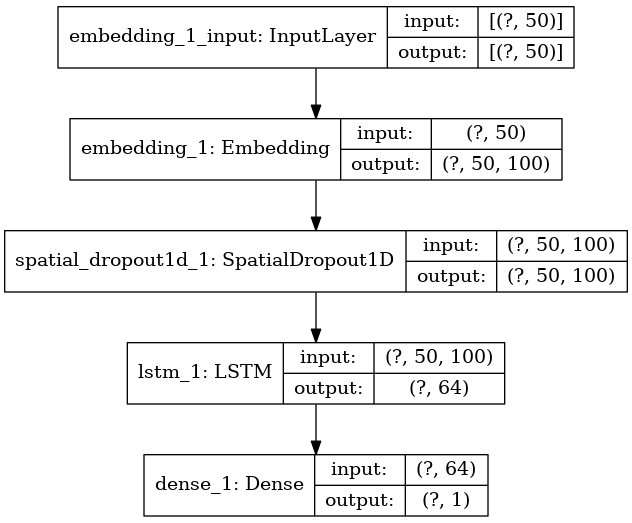

In [11]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, to_file='multichannel.png')

### Train-validate

In [12]:
# train=tweet_pad[:tweet.shape[0]]
# test=tweet_pad[tweet.shape[0]:]
le = LabelEncoder()
y = le.fit_transform(olid['subtask_a'])

X_train, X_valid, y_train, y_valid = train_test_split(tweet_pad, y, test_size=0.33, random_state=42)



# X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_valid.shape)
callback = EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.005 )

history=model.fit(X_train,y_train,
                  batch_size=512,
                  epochs=200,
                  validation_data=(X_valid,y_valid),
                  shuffle = True,
                  verbose=2,
                 callbacks = [callback])

preds_valid = np.round(model.predict(X_valid))
proba_valid = model.predict_proba(X_valid)
preds_train = np.round(model.predict(X_train))
proba_train = model.predict_proba(X_train)

print(classification_report(y_train, preds_train))
print('AUC: ', roc_auc_score(y_train, proba_train))

print(classification_report(y_valid, preds_valid))
print('AUC: ',  roc_auc_score(y_valid, proba_valid))


Shape of train (8870, 50)
Shape of Validation  (4369, 50)
Epoch 1/200
18/18 - 2s - loss: 0.6920 - accuracy: 0.6256 - val_loss: 0.6869 - val_accuracy: 0.6617
Epoch 2/200
18/18 - 2s - loss: 0.6829 - accuracy: 0.6645 - val_loss: 0.6780 - val_accuracy: 0.6658
Epoch 3/200
18/18 - 2s - loss: 0.6737 - accuracy: 0.6674 - val_loss: 0.6683 - val_accuracy: 0.6672
Epoch 4/200
18/18 - 2s - loss: 0.6622 - accuracy: 0.6678 - val_loss: 0.6550 - val_accuracy: 0.6677
Epoch 5/200
18/18 - 2s - loss: 0.6471 - accuracy: 0.6685 - val_loss: 0.6391 - val_accuracy: 0.6677
Epoch 6/200
18/18 - 2s - loss: 0.6349 - accuracy: 0.6679 - val_loss: 0.6317 - val_accuracy: 0.6679
Epoch 7/200
18/18 - 2s - loss: 0.6306 - accuracy: 0.6690 - val_loss: 0.6266 - val_accuracy: 0.6686
Epoch 8/200
18/18 - 2s - loss: 0.6273 - accuracy: 0.6692 - val_loss: 0.6220 - val_accuracy: 0.6693
Epoch 9/200
18/18 - 2s - loss: 0.6225 - accuracy: 0.6696 - val_loss: 0.6146 - val_accuracy: 0.6725
Epoch 10/200
18/18 - 2s - loss: 0.6127 - accuracy: 

### Test

In [13]:
le = LabelEncoder()
y = le.fit_transform(olid['subtask_a'])

y_test = le.transform(olid_test['subtask_a'])
corpus_test = create_corpus(olid_test['tweet_cleaned'])
sequences_test = tokenizer_obj.texts_to_sequences(corpus_test) #??

X_test = pad_sequences(sequences_test,maxlen=MAX_LEN,truncating='post',padding='post')

callback = EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.005 )
history=model.fit(tweet_pad,y,
                  batch_size=512,
                  epochs=100,
                  validation_data=(X_test,y_test),
                  shuffle = True,
                  verbose=2,
                 callbacks = [callback])



print(X_test.shape, y_test.shape)
preds_test = model.predict(X_test)
print(classification_report(y_test, np.round(preds_test)))

print('AUC: ',  roc_auc_score(y_test, preds_test))

100%|██████████| 859/859 [00:00<00:00, 11640.98it/s]


Epoch 1/100
26/26 - 3s - loss: 0.4896 - accuracy: 0.7707 - val_loss: 0.4202 - val_accuracy: 0.8137
Epoch 2/100
26/26 - 3s - loss: 0.4864 - accuracy: 0.7689 - val_loss: 0.4199 - val_accuracy: 0.8196
Epoch 3/100
26/26 - 3s - loss: 0.4842 - accuracy: 0.7702 - val_loss: 0.4199 - val_accuracy: 0.8207
Epoch 4/100
26/26 - 3s - loss: 0.4797 - accuracy: 0.7754 - val_loss: 0.4215 - val_accuracy: 0.8196
Epoch 5/100
26/26 - 3s - loss: 0.4775 - accuracy: 0.7750 - val_loss: 0.4161 - val_accuracy: 0.8207
Epoch 6/100
26/26 - 3s - loss: 0.4747 - accuracy: 0.7782 - val_loss: 0.4152 - val_accuracy: 0.8196
Epoch 7/100
26/26 - 3s - loss: 0.4722 - accuracy: 0.7810 - val_loss: 0.4142 - val_accuracy: 0.8172
Epoch 8/100
26/26 - 3s - loss: 0.4699 - accuracy: 0.7811 - val_loss: 0.4141 - val_accuracy: 0.8242
Epoch 9/100
26/26 - 3s - loss: 0.4677 - accuracy: 0.7817 - val_loss: 0.4132 - val_accuracy: 0.8231
Epoch 10/100
26/26 - 3s - loss: 0.4633 - accuracy: 0.7850 - val_loss: 0.4138 - val_accuracy: 0.8254
Epoch 11/

In [50]:
## TFIDF with NBSVM
## LSTM with GLove
## LSTM with GLove.Twitter
## CNN with Glove
## Gain Chart
y_test.shape

(859,)

# CNN Text v1

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Input, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout, Add
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def create_corpus(tweets):
    stop=set(stopwords.words('english'))
    corpus=[]
    for tweet in tqdm(tweets):
#         words=[word.lower() for word in nltk.casual_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        words=[word.lower() for word in nltk.casual_tokenize(tweet)]
        corpus.append(words)
    return corpus

corpus=create_corpus(olid['tweet_cleaned'])

embedding_dict={}
# with open('./data/glove6B/glove.6B.100d.txt','r') as f:
with open('./data/gloveTwitter27B/glove.twitter.27B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

MAX_LEN=50
filter_sizes = (3, 8)
num_filters = 20
embedding_dim = 100


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus) #??
sequences = tokenizer_obj.texts_to_sequences(corpus) #??

tweet_pad = pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

word_index = tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words,embedding_dim))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec
        

graph_in = Input(shape=(MAX_LEN, embedding_dim))
convs = []
for fsz in filter_sizes:
    conv = Conv1D(filters=num_filters,
                         kernel_size=fsz,
                         padding='valid',
                         activation='tanh',
                         use_bias = True)(graph_in)
                         #,subsample_length=1)(graph_in)
    print(conv)
    pool = GlobalMaxPooling1D()(conv)
    print(pool)
    #flatten = Flatten()(pool)
    convs.append(pool)

if len(filter_sizes)>1:
    out = Concatenate()(convs)
else:
    out = convs[0]

graph = Model(inputs=graph_in, outputs=out)       
        
        
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=True)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(graph)
# model.add(SpatialDropout1D(0.2))
model.add(Dropout(0.5))
# model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

model.summary()

100%|██████████| 19059/19059 [00:00<00:00, 494890.95it/s]

Number of unique words: 19059
Tensor("conv1d/Tanh:0", shape=(None, 48, 20), dtype=float32)
Tensor("global_max_pooling1d/Max:0", shape=(None, 20), dtype=float32)
Tensor("conv1d_1/Tanh:0", shape=(None, 43, 20), dtype=float32)
Tensor("global_max_pooling1d_1/Max:0", shape=(None, 20), dtype=float32)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           1906000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 100)           0         
_________________________________________________________________
functional_1 (Functional)    (None, 40)                22040     
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)       

### Train-validate

In [15]:
# train=tweet_pad[:tweet.shape[0]]
# test=tweet_pad[tweet.shape[0]:]
le = LabelEncoder()
y = le.fit_transform(olid['subtask_a'])

X_train, X_valid, y_train, y_valid = train_test_split(tweet_pad, y, test_size=0.33, random_state=42)



# X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_valid.shape)

callback = EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.005 )
history=model.fit(X_train,y_train,
                  batch_size=512,
                  epochs=200,
                  validation_data=(X_valid,y_valid),
                  shuffle = True,
                  verbose=2,
                 callbacks = [callback])

preds_valid = np.round(model.predict(X_valid))
proba_valid = model.predict_proba(X_valid)
preds_train = np.round(model.predict(X_train))
proba_train = model.predict_proba(X_train)

print(classification_report(y_train, preds_train))
print('AUC: ', roc_auc_score(y_train, proba_train))

print(classification_report(y_valid, preds_valid))
print('AUC: ',  roc_auc_score(y_valid, proba_valid))



Shape of train (8870, 50)
Shape of Validation  (4369, 50)
Epoch 1/100
18/18 - 1s - loss: 0.7438 - accuracy: 0.6285 - val_loss: 0.6568 - val_accuracy: 0.6665
Epoch 2/100
18/18 - 0s - loss: 0.7390 - accuracy: 0.6163 - val_loss: 0.6426 - val_accuracy: 0.6661
Epoch 3/100
18/18 - 0s - loss: 0.7141 - accuracy: 0.6253 - val_loss: 0.6353 - val_accuracy: 0.6670
Epoch 4/100
18/18 - 0s - loss: 0.7110 - accuracy: 0.6188 - val_loss: 0.6297 - val_accuracy: 0.6672
Epoch 5/100
18/18 - 0s - loss: 0.7070 - accuracy: 0.6161 - val_loss: 0.6239 - val_accuracy: 0.6677
Epoch 6/100
18/18 - 0s - loss: 0.7058 - accuracy: 0.6188 - val_loss: 0.6195 - val_accuracy: 0.6681
Epoch 7/100
18/18 - 0s - loss: 0.6934 - accuracy: 0.6267 - val_loss: 0.6146 - val_accuracy: 0.6688
Epoch 8/100
18/18 - 0s - loss: 0.6804 - accuracy: 0.6301 - val_loss: 0.6098 - val_accuracy: 0.6718
Epoch 9/100
18/18 - 1s - loss: 0.6726 - accuracy: 0.6335 - val_loss: 0.6057 - val_accuracy: 0.6718
Epoch 10/100
18/18 - 1s - loss: 0.6663 - accuracy: 

### Test

In [16]:
le = LabelEncoder()
y = le.fit_transform(olid['subtask_a'])

y_test = le.transform(olid_test['subtask_a'])
corpus_test = create_corpus(olid_test['tweet_cleaned'])
sequences_test = tokenizer_obj.texts_to_sequences(corpus_test) #??

X_test = pad_sequences(sequences_test,maxlen=MAX_LEN,truncating='post',padding='post')

callback = EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.005 )

history=model.fit(tweet_pad,y,
                  batch_size=512,
                  epochs=100,
                  validation_data=(X_test,y_test),
                  shuffle = True,
                  verbose=2,
                 callbacks = [callback])



print(X_test.shape, y_test.shape)
preds_test = model.predict(X_test)
print(classification_report(y_test, np.round(preds_test)))

print('AUC: ',  roc_auc_score(y_test, preds_test))

100%|██████████| 859/859 [00:00<00:00, 11730.58it/s]


Epoch 1/100
26/26 - 1s - loss: 0.4412 - accuracy: 0.7996 - val_loss: 0.4096 - val_accuracy: 0.8242
Epoch 2/100
26/26 - 1s - loss: 0.4420 - accuracy: 0.7982 - val_loss: 0.4086 - val_accuracy: 0.8277
Epoch 3/100
26/26 - 1s - loss: 0.4346 - accuracy: 0.8041 - val_loss: 0.4078 - val_accuracy: 0.8289
Epoch 4/100
26/26 - 1s - loss: 0.4337 - accuracy: 0.8043 - val_loss: 0.4069 - val_accuracy: 0.8289
Epoch 5/100
26/26 - 1s - loss: 0.4342 - accuracy: 0.8047 - val_loss: 0.4062 - val_accuracy: 0.8289
Epoch 6/100
26/26 - 1s - loss: 0.4327 - accuracy: 0.8060 - val_loss: 0.4059 - val_accuracy: 0.8231
Epoch 7/100
26/26 - 1s - loss: 0.4279 - accuracy: 0.8068 - val_loss: 0.4055 - val_accuracy: 0.8254
Epoch 8/100
26/26 - 1s - loss: 0.4258 - accuracy: 0.8107 - val_loss: 0.4049 - val_accuracy: 0.8231
Epoch 9/100
26/26 - 1s - loss: 0.4276 - accuracy: 0.8070 - val_loss: 0.4040 - val_accuracy: 0.8231
Epoch 10/100
26/26 - 1s - loss: 0.4193 - accuracy: 0.8128 - val_loss: 0.4040 - val_accuracy: 0.8254
Epoch 11/

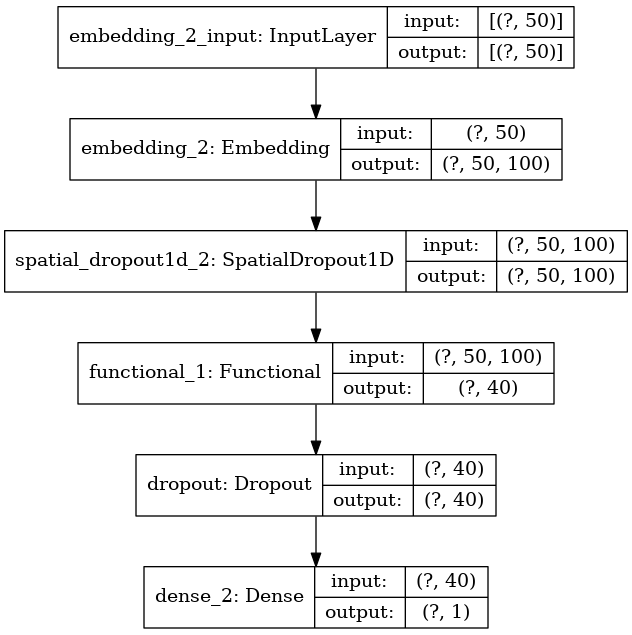

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, to_file='multichannel.png')

# CNN Text v2

In [18]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Input, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout, Add
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def create_corpus(tweets):
    stop=set(stopwords.words('english'))
    corpus=[]
    for tweet in tqdm(tweets):
#         words=[word.lower() for word in nltk.casual_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        words=[word.lower() for word in nltk.casual_tokenize(tweet)]
        corpus.append(words)
    return corpus

corpus=create_corpus(olid['tweet_cleaned'])

embedding_dict={}
# with open('./data/glove6B/glove.6B.100d.txt','r') as f:
with open('./data/gloveTwitter27B/glove.twitter.27B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

MAX_LEN=50
filter_sizes = (3, 8)
num_filters = 20
embedding_dim = 100


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus) #??
sequences = tokenizer_obj.texts_to_sequences(corpus) #??

tweet_pad = pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

word_index = tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words,embedding_dim))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec
        
# channel 1
inputs1 = Input(shape=(MAX_LEN,), name = "trainable")
embedding1 = Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=True)(inputs1)

convs1 = []
for fsz in filter_sizes:
    conv = Conv1D(filters=num_filters,
                         kernel_size=fsz,
                         padding='valid',
                         activation='tanh',
                         use_bias = True)(embedding1)

    convs1.append(conv)

# channel 2
inputs2 = Input(shape=(MAX_LEN,), name = "fixed")
embedding2 = Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)(inputs2)
convs2 = []
for fsz in filter_sizes:
    conv = Conv1D(filters=num_filters,
                         kernel_size=fsz,
                         padding='valid',
                         activation='tanh',
                         use_bias = True)(embedding2)

    convs2.append(conv)
    
pool1 = GlobalMaxPooling1D() (Add()([convs1[0], convs2[0]]))
pool2 = GlobalMaxPooling1D() (Add()([convs1[1], convs2[1]]))

out = Concatenate()([pool1, pool2])

outputs = Dense(1, activation='sigmoid', name = "output")(out)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
optimzer = Adam(learning_rate=1e-4)
# compile
model.compile(loss='binary_crossentropy', optimizer=optimzer, metrics=['accuracy'])

model.summary()


100%|██████████| 19059/19059 [00:00<00:00, 363343.67it/s]

Number of unique words: 19059
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
trainable (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
fixed (InputLayer)              [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 100)      1906000     trainable[0][0]                  
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 50, 100)      1906000     fixed[0][0]                      
_________________________________________________________

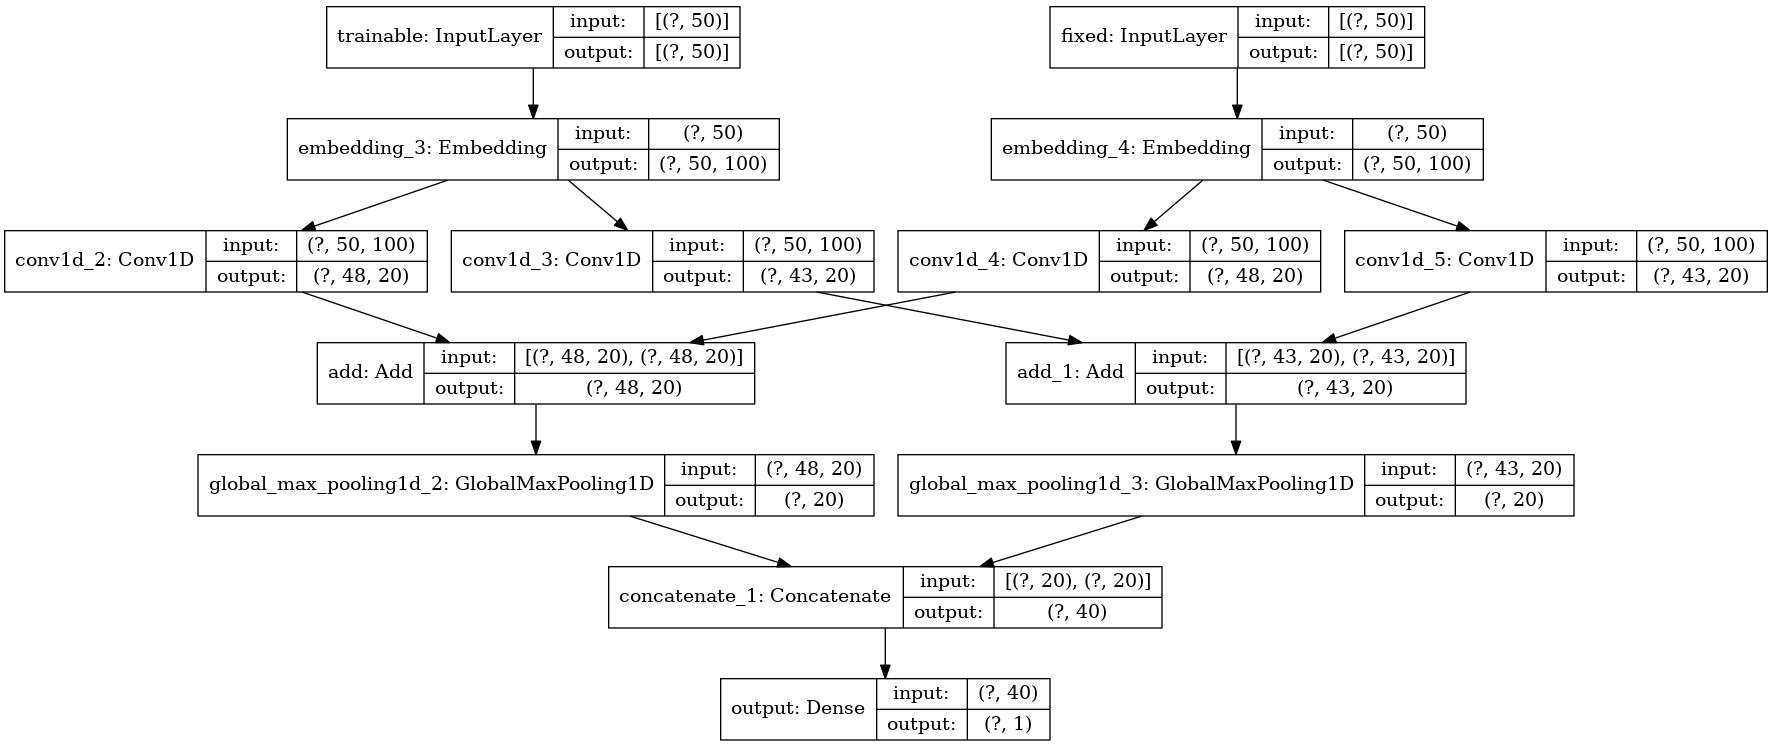

In [19]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, to_file='multichannel.png')

In [20]:
# train=tweet_pad[:tweet.shape[0]]
# test=tweet_pad[tweet.shape[0]:]
le = LabelEncoder()
y = le.fit_transform(olid['subtask_a'])

X_train, X_valid, y_train, y_valid = train_test_split(tweet_pad, y, test_size=0.33, random_state=42)



# X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_valid.shape)

callback = EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.005)

history=model.fit({"fixed": X_train, "trainable": X_train},
                  {"output":y_train},
                  batch_size=512,
                  epochs=200,
                  validation_data=([X_valid,X_valid],y_valid),
                  shuffle = True,
                  verbose=2,
                 callbacks = [callback])

proba_valid = model.predict({'fixed':X_valid,'trainable':X_valid})
proba_train = model.predict({'fixed':X_train,'trainable':X_train})

print(classification_report(y_train, np.round(proba_train)))
print('AUC: ', roc_auc_score(y_train, proba_train))

print(classification_report(y_valid, np.round(proba_valid)))
print('AUC: ',  roc_auc_score(y_valid, proba_valid))


Shape of train (8870, 50)
Shape of Validation  (4369, 50)
Epoch 1/200
18/18 - 1s - loss: 0.6680 - accuracy: 0.5914 - val_loss: 0.6429 - val_accuracy: 0.6590
Epoch 2/200
18/18 - 1s - loss: 0.6342 - accuracy: 0.6629 - val_loss: 0.6336 - val_accuracy: 0.6674
Epoch 3/200
18/18 - 1s - loss: 0.6197 - accuracy: 0.6689 - val_loss: 0.6229 - val_accuracy: 0.6693
Epoch 4/200
18/18 - 1s - loss: 0.6066 - accuracy: 0.6759 - val_loss: 0.6145 - val_accuracy: 0.6741
Epoch 5/200
18/18 - 1s - loss: 0.5947 - accuracy: 0.6833 - val_loss: 0.6065 - val_accuracy: 0.6814
Epoch 6/200
18/18 - 1s - loss: 0.5836 - accuracy: 0.6922 - val_loss: 0.5996 - val_accuracy: 0.6871
Epoch 7/200
18/18 - 1s - loss: 0.5736 - accuracy: 0.6998 - val_loss: 0.5930 - val_accuracy: 0.6928
Epoch 8/200
18/18 - 1s - loss: 0.5639 - accuracy: 0.7069 - val_loss: 0.5872 - val_accuracy: 0.6958
Epoch 9/200
18/18 - 1s - loss: 0.5549 - accuracy: 0.7148 - val_loss: 0.5816 - val_accuracy: 0.6976
Epoch 10/200
18/18 - 1s - loss: 0.5463 - accuracy: 

In [21]:
le = LabelEncoder()
y = le.fit_transform(olid['subtask_a'])

y_test = le.transform(olid_test['subtask_a'])
corpus_test = create_corpus(olid_test['tweet_cleaned'])
sequences_test = tokenizer_obj.texts_to_sequences(corpus_test) #??

X_test = pad_sequences(sequences_test,maxlen=MAX_LEN,truncating='post',padding='post')

callback = EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.005 )

history=model.fit({"fixed":tweet_pad,"trainable":tweet_pad}, 
                  {"output":y},
                  batch_size=512,
                  epochs=100,
                  validation_data=({"fixed":X_test,"trainable":X_test}, 
                  {"output":y_test}),
                  shuffle = True,
                  verbose=2,
                 callbacks = [callback])



print(X_test.shape, y_test.shape)
preds_test = model.predict({"fixed":X_test,"trainable":X_test})
print(classification_report(y_test, np.round(preds_test)))

print('AUC: ',  roc_auc_score(y_test, preds_test))

100%|██████████| 859/859 [00:00<00:00, 11445.69it/s]


Epoch 1/100
26/26 - 1s - loss: 0.3645 - accuracy: 0.8560 - val_loss: 0.4318 - val_accuracy: 0.8265
Epoch 2/100
26/26 - 1s - loss: 0.3587 - accuracy: 0.8597 - val_loss: 0.4314 - val_accuracy: 0.8254
Epoch 3/100
26/26 - 1s - loss: 0.3530 - accuracy: 0.8621 - val_loss: 0.4302 - val_accuracy: 0.8254
Epoch 4/100
26/26 - 1s - loss: 0.3482 - accuracy: 0.8656 - val_loss: 0.4297 - val_accuracy: 0.8277
Epoch 5/100
26/26 - 1s - loss: 0.3431 - accuracy: 0.8677 - val_loss: 0.4283 - val_accuracy: 0.8277
Epoch 6/100
26/26 - 1s - loss: 0.3383 - accuracy: 0.8711 - val_loss: 0.4278 - val_accuracy: 0.8277
Epoch 7/100
26/26 - 1s - loss: 0.3334 - accuracy: 0.8757 - val_loss: 0.4275 - val_accuracy: 0.8277
Epoch 8/100
26/26 - 1s - loss: 0.3292 - accuracy: 0.8763 - val_loss: 0.4266 - val_accuracy: 0.8312
Epoch 9/100
26/26 - 1s - loss: 0.3244 - accuracy: 0.8785 - val_loss: 0.4262 - val_accuracy: 0.8300
Epoch 10/100
26/26 - 1s - loss: 0.3201 - accuracy: 0.8808 - val_loss: 0.4254 - val_accuracy: 0.8312
Epoch 11/

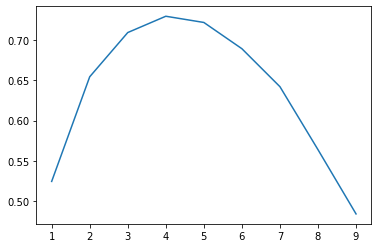

In [39]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

thresholds  = []
scores = []
for th in range(1,10):
    thresholds.append(th)
    
    scores.append(f1_score(y_valid, proba_valid > (th/10), average = 'macro'))
    
plt.plot(thresholds, scores)

In [98]:
print(classification_report(y_test, preds_test > 0.58))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       619
           1       0.83      0.50      0.62       240

    accuracy                           0.83       859
   macro avg       0.83      0.73      0.76       859
weighted avg       0.83      0.83      0.82       859



In [99]:
import pandas as pd

def tp(x,y):
    if x == 1 and y == 1:
        return 1
    else:
        return 0
    
def fp(x,y):
    if x == 0 and y == 1:
        return 1
    else:
        return 0
    
def tn(x,y):
    if x == 0 and y == 0:
        return 1
    else:
        return 0
def fn(x,y):
    if x == 1 and y == 0:
        return 1
    else:
        return 0
    

    

decile_chart_tmp = pd.DataFrame(zip(y_valid, proba_valid.reshape(-1,)))
decile_chart_tmp.columns = ['actuals', 'probabilities']
decile_chart_tmp['deciles'] =  pd.qcut(-decile_chart_tmp['probabilities'], 10, labels = False)
decile_chart_tmp['predictions'] = decile_chart_tmp['probabilities'].apply(lambda x: 1 if x > 0.4 else 0)
decile_chart_tmp['true positives'] = decile_chart_tmp.apply(lambda x: tp(x['actuals'], x['predictions']), axis=1)
decile_chart_tmp['true negatives'] = decile_chart_tmp.apply(lambda x: tn(x['actuals'], x['predictions']), axis=1)
decile_chart_tmp['false negatives'] = decile_chart_tmp.apply(lambda x: fn(x['actuals'], x['predictions']), axis=1)
decile_chart_tmp['false positives'] = decile_chart_tmp.apply(lambda x: fp(x['actuals'], x['predictions']), axis=1)
# decile_chart['correct'] = decile_chart[['predictions','actuals']].apply(lambda (x,y): 1 if x == y else 0)
decile_chart = decile_chart_tmp.groupby(['deciles']).agg({'probabilities':[min, max], 'actuals':[sum, len], 
                                                          'true positives': sum, 'true negatives': sum,
                                                         'false positives': sum, 'false negatives': sum})

decile_chart

probabilities           actuals      true positives true negatives  \
                  min       max     sum  len            sum            sum   
deciles                                                                      
0            0.750020  0.997033     360  437            360              0   
1            0.581806  0.749938     286  437            286              0   
2            0.443926  0.581631     219  437            219              0   
3            0.343517  0.443746     177  438             75            167   
4            0.260830  0.343486     124  436              0            312   
5            0.191356  0.260585     102  436              0            334   
6            0.139107  0.191322      80  437              0            357   
7            0.089370  0.139073      63  437              0            374   
8            0.050816  0.089211      29  437              0            408   
9            0.004408  0.050770      12  437              0            425   

        false positives false negatives  
                    sum             sum  
deciles                                  
0                    77               0  
1                   151               0  
2                   218               0  
3                    94             102  
4                     0             124  
5                     0             102  
6                     0              80  
7                     0              63  
8                     0              29  
9                     0              12

In [89]:
X_valid[(decile_chart['deciles'] == 9) & (decile_chart['actuals'] == 0)]

array([[    9,    69,   302, ...,     0,     0,     0],
       [   32,   355,   137, ...,     0,     0,     0],
       [   30,     2, 12322, ...,     0,     0,     0],
       ...,
       [11449,  7216,   181, ...,     0,     0,     0],
       [   57,     5,    97, ...,     0,     0,     0],
       [   15,    40,   938, ...,     0,     0,     0]], dtype=int32)

In [61]:
proba_valid.reshape(-1,)

array([0.4228484 , 0.08546638, 0.05872276, ..., 0.05901635, 0.2741836 ,
       0.30801404], dtype=float32)